
## Урок 8. На практике использование методов генерации признаков
В вашем распоряжении набор данных о качестве сна Sleep_health_and_lifestyle_dataset.csv.
Ваша задача — подготовить данные к моделированию, сгенерировать новые признаки, применить методы отбора признаков для улучшения качества предсказательной модели и подобрать оптимальные гиперпараметры для модели регрессии.

1. Предобработка данных:
    - Очистите данные от пропусков и аномалий.
    - Преобразуйте категориальные переменные с помощью One-Hot Encoding или Label Encoding.

2. Генерация новых признаков:
    - Создайте комбинированные признаки, которые могут помочь улучшить модель.
    - Используйте полиномиальные признаки для числовых переменных.

3. Отбор признаков:
    - Примените несколько методов отбора признаков (например, RFE, SelectKBest).
    - Сравните качество модели до и после отбора признаков.

4. Подбор гиперпараметров:
    - Используйте GridSearchCV или RandomizedSearchCV для настройки параметров вашей модели регрессии.
    - Оцените, как изменение гиперпараметров влияет на качество предсказаний.

### 1. Предобработка данных:

In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier

In [472]:
# Загрузка данных
file_path = 'Sleep_health_and_lifestyle_dataset.csv'
df = pd.read_csv(file_path)

# Первичный анализ данных
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [474]:
df.describe().round(2)

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.00,374.00,374.00,374.00,374.00,374.00,374.00,374.00
mean,187.50,42.18,7.13,7.31,59.17,5.39,70.17,6816.84
std,108.11,8.67,0.80,1.20,20.83,1.77,4.14,1617.92
min,1.00,27.00,5.80,4.00,30.00,3.00,65.00,3000.00
25%,94.25,35.25,6.40,6.00,45.00,4.00,68.00,5600.00
50%,187.50,43.00,7.20,7.00,60.00,5.00,70.00,7000.00
75%,280.75,50.00,7.80,8.00,75.00,7.00,72.00,8000.00
max,374.00,59.00,8.50,9.00,90.00,8.00,86.00,10000.00


DataFrame, содержит 374 записи и 13 Признаков. Из них 6 категориальные.

**Категориальные:**
1. Person ID (Идентификатор человека)
2. Gender (Пол)
3. Occupation (Профессия)
4. BMI Category (Категория ИМТ)
5. Blood Pressure (Артериальное давление)
6. Sleep Disorder (Нарушение сна)

**Количественные:**
1. Age (Возраст)
2. Sleep Duration (Продолжительность сна)
3. Quality of Sleep (Качество сна)
4. Physical Activity Level (Уровень физической активности)
5. Stress Level (Уровень стресса)
6. Heart Rate (Пульс)
7. Daily Steps (Ежедневные шаги)


В признаке Sleep Disorder есть 219 попущенных значений, будем считать их отсутствием нарушений сна.

In [475]:
# Заменим "Blood Pressure" на два столбца
new_df = df.copy()
new_df[['Systolic', 'Diastolic']] = new_df['Blood Pressure'].str.split('/', expand=True).astype(int)
new_df = new_df.drop('Blood Pressure', axis=1)
# Удалим Person ID
new_df = new_df.drop('Person ID', axis=1)
new_df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,NaN,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


In [476]:
new_df.describe()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920,128.553476,84.649733
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679,7.748118,6.161611
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000,115.000000,75.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000,125.000000,80.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000,130.000000,85.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000,135.000000,90.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000,142.000000,95.000000


Выбросов в данных нет

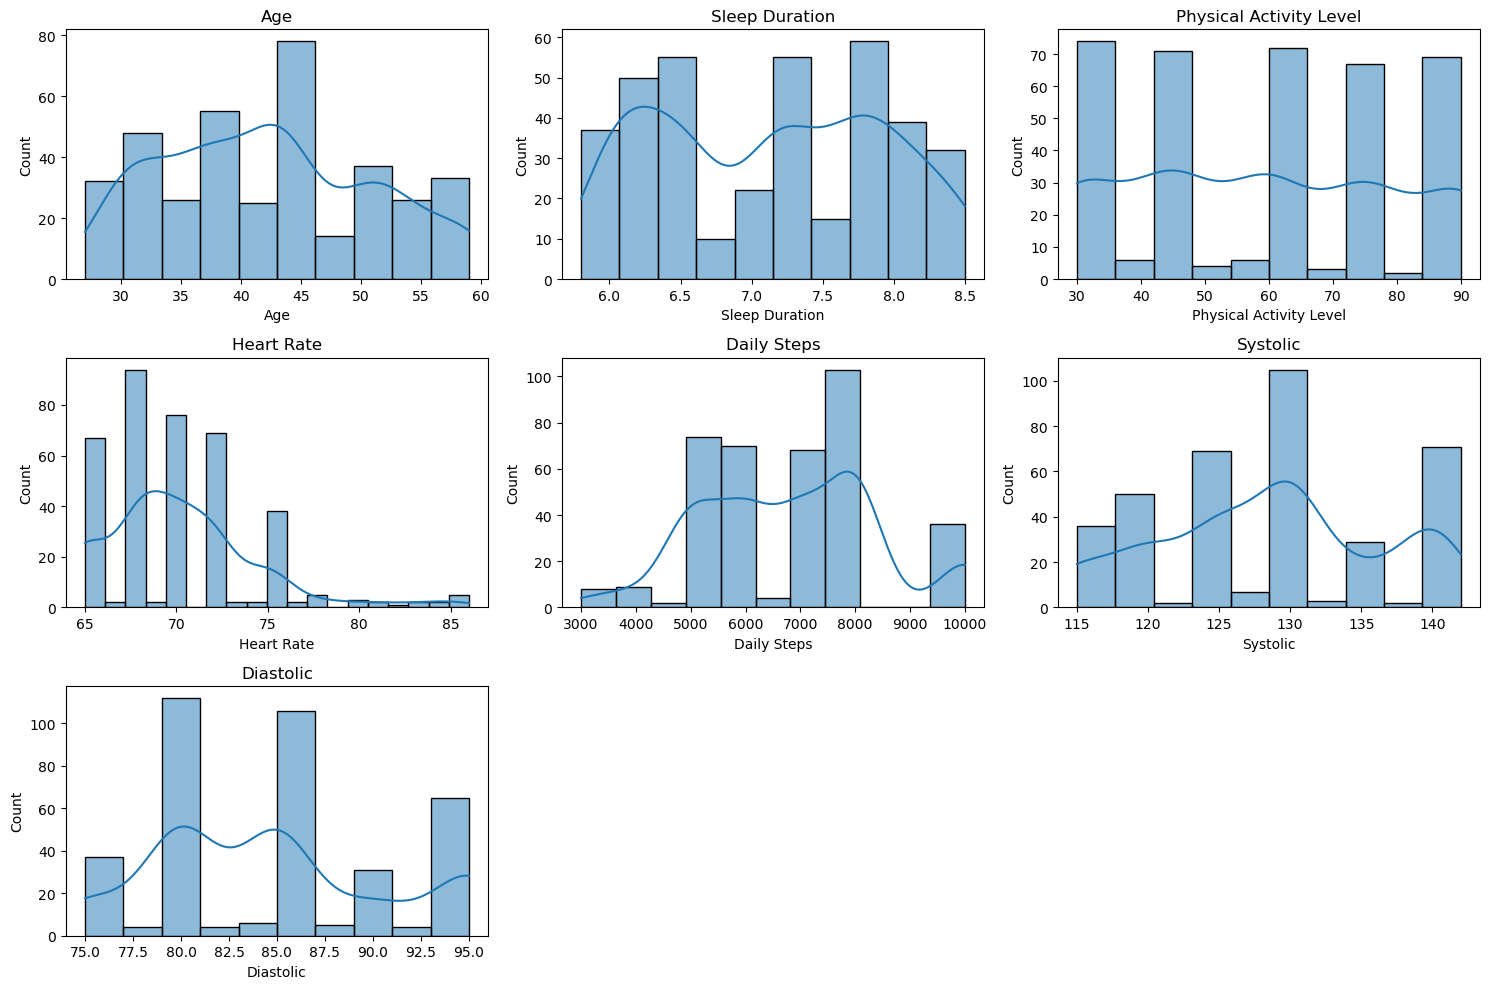

In [367]:
# Рассмотрим  количественные признаки
numeric_features = ['Age', 'Sleep Duration', 'Physical Activity Level', 'Heart Rate',
                    'Daily Steps','Systolic', 'Diastolic']

# Создаем графики
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(new_df[feature], kde=True)
    plt.title(feature)
    plt.tight_layout()

plt.show()


Выбросов в данных нет

In [477]:
# Список значений категориальных параметров

categorical_cols = df[['Gender', 'Occupation', 'Quality of Sleep', 'Stress Level',	'BMI Category',	'Sleep Disorder']].columns.tolist()

for col in categorical_cols:
    print(f"{col}: {df[col].unique()}\n")

Gender: ['Male' 'Female']

Occupation: ['Software Engineer' 'Doctor' 'Sales Representative' 'Teacher' 'Nurse'
 'Engineer' 'Accountant' 'Scientist' 'Lawyer' 'Salesperson' 'Manager']

Quality of Sleep: [6 4 7 5 8 9]

Stress Level: [6 8 7 4 3 5]

BMI Category: ['Overweight' 'Normal' 'Obese' 'Normal Weight']

Sleep Disorder: [nan 'Sleep Apnea' 'Insomnia']



In [478]:
#признаки 'Quality of Sleep', 'Stress Level' так же отнесем к категориальным и перекодируем из при помощи LabelEncoder, что бы они начинались с 0
from sklearn.preprocessing import LabelEncoder
selected_columns = new_df.loc[:, ['Quality of Sleep', 'Stress Level']]
# Создание LabelEncoder объекта
label_encoder = LabelEncoder()

# Кодирование столбцов
encoded_columns = {}
for column in selected_columns:
    new_df[column + '_encoded'] = label_encoder.fit_transform(new_df[column])
    # Сохраняем маппинг
    encoded_columns[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Вывод легенды кодировки для каждого столбца
for column, mapping in encoded_columns.items():
    print(f"Кодировка для {column}:", mapping)

new_df.drop(['Quality of Sleep', 'Stress Level'], axis=1, inplace=True)

# Вывод DataFrame
display(new_df)


Кодировка для Quality of Sleep: {4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5}
Кодировка для Stress Level: {3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5}


,Gender,Age,Occupation,Sleep Duration,Physical Activity Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic,Quality of Sleep_encoded,Stress Level_encoded
0,Male,27,Software Engineer,6.1,42,Overweight,77,4200,NaN,126,83,2,3
1,Male,28,Doctor,6.2,60,Normal,75,10000,NaN,125,80,2,5
2,Male,28,Doctor,6.2,60,Normal,75,10000,NaN,125,80,2,5
3,Male,28,Sales Representative,5.9,30,Obese,85,3000,Sleep Apnea,140,90,0,5
4,Male,28,Sales Representative,5.9,30,Obese,85,3000,Sleep Apnea,140,90,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,75,Overweight,68,7000,Sleep Apnea,140,95,5,0
370,Female,59,Nurse,8.0,75,Overweight,68,7000,Sleep Apnea,140,95,5,0
371,Female,59,Nurse,8.1,75,Overweight,68,7000,Sleep Apnea,140,95,5,0
372,Female,59,Nurse,8.1,75,Overweight,68,7000,Sleep Apnea,140,95,5,0


In [479]:
new_df['Sleep Disorder']=new_df['Sleep Disorder'].fillna('No')

In [480]:
# Преобразование категориальных переменных с помощью One-Hot Encoding

one_hot_columns = new_df.loc[:, ['Gender', 'BMI Category', 'Sleep Disorder']]
for column in one_hot_columns:
    encoded_columns = pd.get_dummies(new_df[column]).astype('int32')
    for encoded_column in encoded_columns:
        label = (column+' '+encoded_column)
        new_df[label] = encoded_columns[encoded_column]

In [481]:
# Вычисляем количество встречаемости каждого уникального значения в колонке
occupation_counts = df['Occupation'].value_counts()

# Закодируем 'Occupation' на основе количества встречаемости
new_df['Occupation_encoded'] = new_df['Occupation'].map(occupation_counts)
new_df=new_df.drop(['Gender', 'BMI Category', 'Sleep Disorder', 'Occupation'], axis=1)

In [482]:
new_df.T

,0,1,2,3,4,5,6,7,8,9,...,364,365,366,367,368,369,370,371,372,373
Age,27.0,28.0,28.0,28.0,28.0,28.0,29.0,29.0,29.0,29.0,...,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0
Sleep Duration,6.1,6.2,6.2,5.9,5.9,5.9,6.3,7.8,7.8,7.8,...,8.0,8.0,8.1,8.0,8.1,8.1,8.0,8.1,8.1,8.1
Physical Activity Level,42.0,60.0,60.0,30.0,30.0,30.0,40.0,75.0,75.0,75.0,...,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0
Heart Rate,77.0,75.0,75.0,85.0,85.0,85.0,82.0,70.0,70.0,70.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
Daily Steps,4200.0,10000.0,10000.0,3000.0,3000.0,3000.0,3500.0,8000.0,8000.0,8000.0,...,7000.0,7000.0,7000.0,7000.0,7000.0,7000.0,7000.0,7000.0,7000.0,7000.0
Systolic,126.0,125.0,125.0,140.0,140.0,140.0,140.0,120.0,120.0,120.0,...,140.0,140.0,140.0,140.0,140.0,140.0,140.0,140.0,140.0,140.0
Diastolic,83.0,80.0,80.0,90.0,90.0,90.0,90.0,80.0,80.0,80.0,...,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0
Quality of Sleep_encoded,2.0,2.0,2.0,0.0,0.0,0.0,2.0,3.0,3.0,3.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Stress Level_encoded,3.0,5.0,5.0,5.0,5.0,5.0,4.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gender Female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### 3. Отбор признаков:

In [483]:
# Разделение данных на обучающую и тестовую выборки
X = new_df.drop('Quality of Sleep_encoded', axis=1)
y = new_df['Quality of Sleep_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [484]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели без отбора признаков
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print('Без отбора признаков:')
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

# Отбор признаков с помощью RFE
selector_rfe = RFE(model, n_features_to_select=10)
selector_rfe.fit(X_train_scaled, y_train)
X_train_rfe = selector_rfe.transform(X_train_scaled)
X_test_rfe = selector_rfe.transform(X_test_scaled)

# Обучение модели с RFE
model.fit(X_train_rfe, y_train)
y_pred_rfe = model.predict(X_test_rfe)
print('\nС отбором признаков (RFE):')
print('MSE:', mean_squared_error(y_test, y_pred_rfe))
print('R2:', r2_score(y_test, y_pred_rfe))

Без отбора признаков:
MSE: 0.0
R2: 1.0

С отбором признаков (RFE):
MSE: 0.0
R2: 1.0


In [469]:
#Оценим качество модели при помощи 5 кратной валидации
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f'Среднее значение R^2 по 5-кратной кросс-валидации: {cross_val_scores.mean().round(3)}')

Среднее значение R^2 по 5-кратной кросс-валидации: 0.893


Отбор признаков с помощью RFE не улучшил качество модели. Средний коэффициент детерминации модели по итогам 5 кратной кроссвалидации равен 0,893.

### 4. Подбор гиперпараметров:

In [470]:
# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 5, 7],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_rfe, y_train)

# Лучшие параметры и оценка
print('\nЛучшие параметры:', grid_search.best_params_)
print('Лучшая оценка (MSE):', -grid_search.best_score_)

# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_rfe)
print('\nС лучшими параметрами:')
print('MSE:', mean_squared_error(y_test, y_pred_best))
print('R2:', r2_score(y_test, y_pred_best))



Лучшие параметры: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Лучшая оценка (MSE): 0.040056497175141245

С лучшими параметрами:
MSE: 0.02666666666666667
R2: 0.9823238274805562


Подбор гиперпараметров с помощью GridSearchCV позволил найти
оптимальные настройки для модели, что привело к увеличению коэффициента детерминации модели до 0,982.

### 2. Генерация новых признаков:

In [485]:
# Попробуем добавить полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(new_df[numeric_features])

# Добавление новых признаков
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(numeric_features))
poly_df = pd.concat([new_df.reset_index(drop=True), poly_features_df], axis=1)
poly_df.head()

,Age,Sleep Duration,Physical Activity Level,Heart Rate,Daily Steps,Systolic,Diastolic,Quality of Sleep_encoded,Stress Level_encoded,Gender Female,...,Heart Rate^2,Heart Rate Daily Steps,Heart Rate Systolic,Heart Rate Diastolic,Daily Steps^2,Daily Steps Systolic,Daily Steps Diastolic,Systolic^2,Systolic Diastolic,Diastolic^2
0,27,6.1,42,77,4200,126,83,2,3,0,...,5929.0,323400.0,9702.0,6391.0,17640000.0,529200.0,348600.0,15876.0,10458.0,6889.0
1,28,6.2,60,75,10000,125,80,2,5,0,...,5625.0,750000.0,9375.0,6000.0,100000000.0,1250000.0,800000.0,15625.0,10000.0,6400.0
2,28,6.2,60,75,10000,125,80,2,5,0,...,5625.0,750000.0,9375.0,6000.0,100000000.0,1250000.0,800000.0,15625.0,10000.0,6400.0
3,28,5.9,30,85,3000,140,90,0,5,0,...,7225.0,255000.0,11900.0,7650.0,9000000.0,420000.0,270000.0,19600.0,12600.0,8100.0
4,28,5.9,30,85,3000,140,90,0,5,0,...,7225.0,255000.0,11900.0,7650.0,9000000.0,420000.0,270000.0,19600.0,12600.0,8100.0


In [489]:
#Заново произведем обучение модели 
# Разделение данных на обучающую и тестовую выборки
X = poly_df.drop('Quality of Sleep_encoded', axis=1)
y = poly_df['Quality of Sleep_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [490]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели без отбора признаков
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print('Без отбора признаков:')
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

# Отбор признаков с помощью RFE
selector_rfe = RFE(model, n_features_to_select=10)
selector_rfe.fit(X_train_scaled, y_train)
X_train_rfe = selector_rfe.transform(X_train_scaled)
X_test_rfe = selector_rfe.transform(X_test_scaled)

# Обучение модели с RFE
model.fit(X_train_rfe, y_train)
y_pred_rfe = model.predict(X_test_rfe)
print('\nС отбором признаков (RFE):')
print('MSE:', mean_squared_error(y_test, y_pred_rfe))
print('R2:', r2_score(y_test, y_pred_rfe))

Без отбора признаков:
MSE: 0.013333333333333334
R2: 0.9911619137402781

С отбором признаков (RFE):
MSE: 0.013333333333333334
R2: 0.9911619137402781


In [491]:
#Оценим качество модели при помощи 5 кратной валидации
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f'Среднее значение R^2 по 5-кратной кросс-валидации: {cross_val_scores.mean().round(3)}')

Среднее значение R^2 по 5-кратной кросс-валидации: 0.904


Добавление полиномиальных признаков позволило улучшить средний коэффициент детерминации модели по итогам 5 кратной кроссвалидации равен с 0,893 до 0,904

In [492]:
# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 5, 7],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_rfe, y_train)

# Лучшие параметры и оценка
print('\nЛучшие параметры:', grid_search.best_params_)
print('Лучшая оценка (MSE):', -grid_search.best_score_)

# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_rfe)
print('\nС лучшими параметрами:')
print('MSE:', mean_squared_error(y_test, y_pred_best))
print('R2:', r2_score(y_test, y_pred_best))



Лучшие параметры: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Лучшая оценка (MSE): 0.039999999999999994

С лучшими параметрами:
MSE: 0.04
R2: 0.9734857412208343


После подбора параметров при помощи GridSearchCV средний коэффициент детерминации модели составил 0,973, однако он ниже, чем в модели без полиномиальных признаков (0,982).

In [497]:
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

# Define your model and search space
search_space = {
    "max_depth": Integer(6, 10),
    "max_features": Categorical(['auto', 'sqrt']),
    "min_samples_leaf": Integer(3, 5),
    "min_samples_split": Integer(4, 6),

}

# Initialize BayesSearchCV
clf_bayes = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    random_state=42,
    cv=5,
    verbose=2,
    n_jobs=-1
)
clf_bayes.fit(X_train_rfe, y_train)

# Get the best hyperparameters and R2 score
best_params = clf_bayes.best_params_
best_r2 = clf_bayes.best_score_

print(f"Лучшие гиперпараметры (Bayesian Optimization): {best_params}")
print(f"Лучшая оценка (Bayesian Optimization): {best_r2:.2f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Байесовская оптимизация выдала модель с коэффициентом детерминации 0,95. Таким образом наилучшее качество модели достигнуто при отсутсвии полиномиальных признаков, параметрах 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50. Коэффициент детерминации по итогам 5 красной валидации составил 0,982.